# LETID - Outdoor Geospatioal Demo

![PVDeg Logo](../PVD_logo.png)

***
2023.10.13 - J. Karas, M. Springer
***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pvdeg
from pvdeg import DATA_DIR
import dask.array as da
import dask.dataframe as dd
import xarray as xr
import os

# Single location example

In [2]:
weather_file = os.path.join(DATA_DIR,'psm3_demo.csv')
WEATHER, META = pvdeg.weather.read(weather_file,'psm')

In [3]:
kwargs = {'tau_0': 115, # us, carrier lifetime in non-degraded states, e.g. LETID/LID states A or C
        'tau_deg': 55, # us, carrier lifetime in fully-degraded state, e.g. LETID/LID state B
        'wafer_thickness': 180, # um
        's_rear': 46, # cm/s
        'cell_area': 243, # cm^2
        'na_0': 100,
        'nb_0': 0,
        'nc_0': 0,
        'mechanism_params': 'repins'
    }

In [4]:
pvdeg.letid.calc_letid_outdoors(weather_df=WEATHER, meta=META, **kwargs)

,Temperature,Injection,NA,NB,NC,tau,Jsc,Voc,Isc,FF,Pmp,Pmp_norm
time,,,,,,,,,,,,
1999-01-01 00:30:00-07:00,0.0,NaN,100.000000,0.000000e+00,0.000000e+00,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000
1999-01-01 01:30:00-07:00,0.0,NaN,100.000000,1.702422e-15,0.000000e+00,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000
1999-01-01 02:30:00-07:00,0.0,NaN,100.000000,3.404843e-15,5.403329e-36,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000
1999-01-01 03:30:00-07:00,0.0,NaN,100.000000,5.107265e-15,1.620999e-35,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000
1999-01-01 04:30:00-07:00,0.0,NaN,100.000000,6.809686e-15,3.241997e-35,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1999-12-31 19:30:00-07:00,0.0,NaN,27.833654,6.778463e+01,4.381716e+00,66.112142,41.333851,0.654974,10.044126,0.838966,5.519257,0.974537
1999-12-31 20:30:00-07:00,0.0,NaN,27.833654,6.778463e+01,4.381716e+00,66.112142,41.333851,0.654974,10.044126,0.838966,5.519257,0.974537
1999-12-31 21:30:00-07:00,0.0,NaN,27.833654,6.778463e+01,4.381716e+00,66.112142,41.333851,0.654974,10.044126,0.838966,5.519257,0.974537


## 1 Start distributed compute cluster - DASK

In [5]:
local = {'manager': 'local',
         'n_workers': 1,
         'threads_per_worker': 8, # Number of CPUs
         }

kestrel = {
    'manager': 'slurm',
    'n_jobs': 1,  # Number of nodes used for parallel processing
    'cores': 104,
    'memory': '256GB',
    'account': 'pvsoiling',
    'queue': 'debug',
    'walltime': '1:00:00',
    'processes': 52,
    'local_directory': '/tmp/scratch',
    'job_extra_directives': ['-o ./logs/slurm-%j.out'],
    'death_timeout': 600,}

pvdeg.geospatial.start_dask(hpc=kestrel)

Dashboard: http://10.60.1.200:8787/status


<Client: 'tcp://10.60.1.200:33703' processes=0 threads=0, memory=0 B>

In [6]:
# Get weather data
weather_db = 'NSRDB'

weather_arg = {'satellite': 'Americas',
               'names': 2022,
               'NREL_HPC': True,
               'attributes': ['air_temperature', 'wind_speed', 'dhi', 'ghi', 'dni', 'relative_humidity']}

weather_ds, meta_df = pvdeg.weather.get(weather_db, geospatial=True, **weather_arg)

# Define geographical region
meta_CO = meta_df[meta_df['state'] == 'Colorado']
meta_CO_sub, gids_NM_sub = pvdeg.utilities.gid_downsampling(meta_CO, 6)

weather_CO_sub = weather_ds.sel(gid=meta_CO_sub.index)

In [7]:
# Define desired analysis
geo = {'func': pvdeg.letid.calc_letid_outdoors,
       'weather_ds': weather_CO_sub,
       'meta_df': meta_CO_sub,
       'tau_0': 115, # us, carrier lifetime in non-degraded states, e.g. LETID/LID states A or C
       'tau_deg': 55, # us, carrier lifetime in fully-degraded state, e.g. LETID/LID state B
       'wafer_thickness': 180, # um
       's_rear': 46, # cm/s
       'cell_area': 243, # cm^2
       'na_0': 100,
       'nb_0': 0,
       'nc_0': 0,
       'mechanism_params': 'repins'
}

letid_res = pvdeg.geospatial.analysis(**geo)

In [ ]:
letid_res

<xarray.Dataset>
Dimensions:      (latitude: 9, longitude: 15, time: 17520)
Coordinates:
  * latitude     (latitude) float32 37.01 37.49 37.97 ... 39.89 40.37 40.85
  * longitude    (longitude) float32 -109.1 -108.6 -108.1 ... -102.8 -102.3
  * time         (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:30:00
Data variables:
    Temperature  (time, latitude, longitude) float64 nan -0.7 ... 3.55 2.677
    Injection    (time, latitude, longitude) float64 nan nan ... 0.000174
    NA           (time, latitude, longitude) float64 nan 100.0 ... 31.49 36.49
    NB           (time, latitude, longitude) float64 nan 0.0 0.0 ... 58.38 54.01
    NC           (time, latitude, longitude) float64 nan 0.0 0.0 ... 10.13 9.506
    tau          (time, latitude, longitude) float64 nan 115.0 ... 70.26 72.36
    Jsc          (time, latitude, longitude) float64 nan 41.59 ... 41.37 41.39
    Voc          (time, latitude, longitude) float64 nan 0.6663 ... 0.6569
    Isc          (time, latitude, longitude) float64 nan 10.11 ... 10.05 10.06
    FF           (time, latitude, longitude) float64 nan 0.841 ... 0.8392 0.8393
    Pmp          (time, latitude, longitude) float64 nan 5.663 ... 5.536 5.545
    Pmp_norm     (time, latitude, longitude) float64 nan 1.0 ... 0.9776 0.979

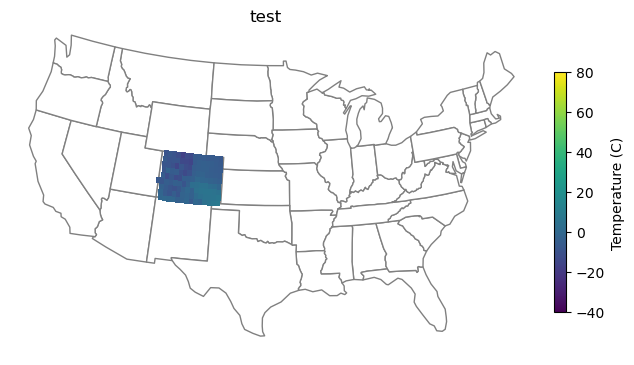

In [ ]:
# Plot results
fig, ax = pvdeg.geospatial.plot_USA(letid_res['Temperature'].sel(time='2022-01-01T00:00:00.000000000'),
        cmap='viridis', vmin=-40, vmax=80,
        title=f'test',
        cb_title='Temperature (C)')